In [1]:
import requests
import pandas as pd

In [2]:
url = "https://data.cityofnewyork.us/resource/eabe-havv.json?$query=SELECT%0A%20%20%60complaint_number%60%2C%0A%20%20%60status%60%2C%0A%20%20%60date_entered%60%2C%0A%20%20%60house_number%60%2C%0A%20%20%60house_street%60%2C%0A%20%20%60zip_code%60%2C%0A%20%20%60bin%60%2C%0A%20%20%60community_board%60%2C%0A%20%20%60special_district%60%2C%0A%20%20%60complaint_category%60%2C%0A%20%20%60unit%60%2C%0A%20%20%60disposition_date%60%2C%0A%20%20%60disposition_code%60%2C%0A%20%20%60inspection_date%60%2C%0A%20%20%60dobrundate%60%0AWHERE%0A%20%20%60date_entered%60%0A%20%20%20%20BETWEEN%20%2201%2F01%2F2024%2012%3A00%3A00AM%22%0A%20%20%20%20AND%20%2212%2F31%2F2024%2011%3A59%3A59%22"

print("Fetching data...")
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_complaints = pd.DataFrame(data)
    print(f"Successfully retrieved {len(df_complaints)} rows!")
    print(df_complaints.head())
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Fetching data...
Successfully retrieved 1000 rows!
  complaint_number  status date_entered house_number    house_street zip_code  \
0          5189174  CLOSED   03/13/2025          141      PINE PLACE    10304   
1          4061982  CLOSED   03/14/1997        57-20      134 STREET    11355   
2          4931465  CLOSED   07/17/2023        31-40      100 STREET    11369   
3          4619111  CLOSED   05/19/2015        70-04      171 STREET    11365   
4          2365467  CLOSED   05/10/2023         1451  NEEDHAM AVENUE    10469   

       bin community_board complaint_category  unit disposition_date  \
0  5014257             501                 7G   CSE       03/13/2025   
1  4139091             407                 48  QNS.       04/29/1997   
2  4034464             403                 1X  QNS.       07/18/2023   
3  4150065             408                 05  QNS.       05/26/2015   
4  2128765             212                 45   Q-L       06/16/2023   

  disposition_code inspection

In [3]:
url = "https://data.cityofnewyork.us/api/v3/views/3h2n-5cm9/query.json?query=SELECT%0A%20%20%60isn_dob_bis_viol%60%2C%0A%20%20%60boro%60%2C%0A%20%20%60bin%60%2C%0A%20%20%60block%60%2C%0A%20%20%60lot%60%2C%0A%20%20%60issue_date%60%2C%0A%20%20%60violation_type_code%60%2C%0A%20%20%60violation_number%60%2C%0A%20%20%60house_number%60%2C%0A%20%20%60street%60%2C%0A%20%20%60disposition_date%60%2C%0A%20%20%60disposition_comments%60%2C%0A%20%20%60device_number%60%2C%0A%20%20%60description%60%2C%0A%20%20%60ecb_number%60%2C%0A%20%20%60number%60%2C%0A%20%20%60violation_category%60%2C%0A%20%20%60violation_type%60"

print("Fetching data...")
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_violations = pd.DataFrame(data)
    print(f"Successfully retrieved {len(df_violations)} rows!")
    print(df_violations.head())
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Fetching data...
Error: 403
{
  "code" : "authentication_required",
  "error" : true,
  "message" : "This request must be authenticated or have an application token"
}



In [6]:
import requests
import pandas as pd

# URLs for your filtered endpoints
complaints_url = "https://data.cityofnewyork.us/resource/eabe-havv.json?$query=SELECT%20complaint_number,%20status,%20date_entered,%20bin,%20complaint_category%20WHERE%20date_entered%20BETWEEN%20%2201/01/2024%2012:00:00AM%22%20AND%20%2212/31/2024%2011:59:59PM%22"
violations_url = "https://data.cityofnewyork.us/resource/3h2n-5cm9.json?$query=SELECT%20isn_dob_bis_viol,%20boro,%20bin,%20issue_date,%20violation_type,%20description%20WHERE%20issue_date%20BETWEEN%20%2220240101%22%20AND%20%2220241231%22"

print("Fetching Complaints and Violations...")

# Get Data
r_comp = requests.get(complaints_url)
r_viol = requests.get(violations_url)

if r_comp.status_code == 200 and r_viol.status_code == 200:
    df_comp = pd.DataFrame(r_comp.json())
    df_viol = pd.DataFrame(r_viol.json())
    
    # Standardize Borough names in Violations (Boro codes: 1=MN, 2=BX, 3=BK, 4=QN, 5=SI)
    boro_map = {'1': 'MANHATTAN', '2': 'BRONX', '3': 'BROOKLYN', '4': 'QUEENS', '5': 'STATEN ISLAND'}
    df_viol['boro_name'] = df_viol['boro'].map(boro_map)
    
    # Fix Complaint Boroughs (extracting from BIN first digit as discussed)
    df_comp['boro_name'] = df_comp['bin'].str[0].map(boro_map)

    # --- THE COMPARISON ---
    # Group by BIN to see how many complaints vs violations per building
    comp_stats = df_comp.groupby(['bin', 'boro_name']).size().reset_index(name='complaint_count')
    viol_stats = df_viol.groupby('bin').size().reset_index(name='violation_count')

    # Join the two datasets on 'bin'
    # 'outer' join ensures we see buildings that have ONLY complaints OR ONLY violations
    comparison = pd.merge(comp_stats, viol_stats, on='bin', how='outer').fillna(0)

    print("\nComparison Success!")
    print(comparison.head(1000))
    
else:
    print("Error fetching data. Check your API limits or URLs.")

Fetching Complaints and Violations...

Comparison Success!
         bin  boro_name  complaint_count  violation_count
0    1000811          0              0.0              1.0
1    1000854          0              0.0              1.0
2    1000865  MANHATTAN              1.0              0.0
3    1001021  MANHATTAN              1.0              0.0
4    1001033  MANHATTAN              1.0              0.0
..       ...        ...              ...              ...
995  3142329          0              0.0              2.0
996  3142470   BROOKLYN              1.0              0.0
997  3142537          0              0.0              1.0
998  3144131   BROOKLYN              1.0              0.0
999  3144195          0              0.0              1.0

[1000 rows x 4 columns]


In [7]:
# Create a conversion ratio
comparison['ratio'] = comparison['complaint_count'] / (comparison['violation_count'] + 0.1) # +0.1 to avoid divide by zero
avg_efficiency = comparison.groupby('boro_name')['ratio'].mean()
print(avg_efficiency)

boro_name
0                 0.000000
BRONX             9.914966
BROOKLYN         10.000000
MANHATTAN         9.836875
QUEENS           10.033670
STATEN ISLAND    10.000000
Name: ratio, dtype: float64


Fetching live 2024 data from NYC Open Data...
Error fetching data. Check your connection.


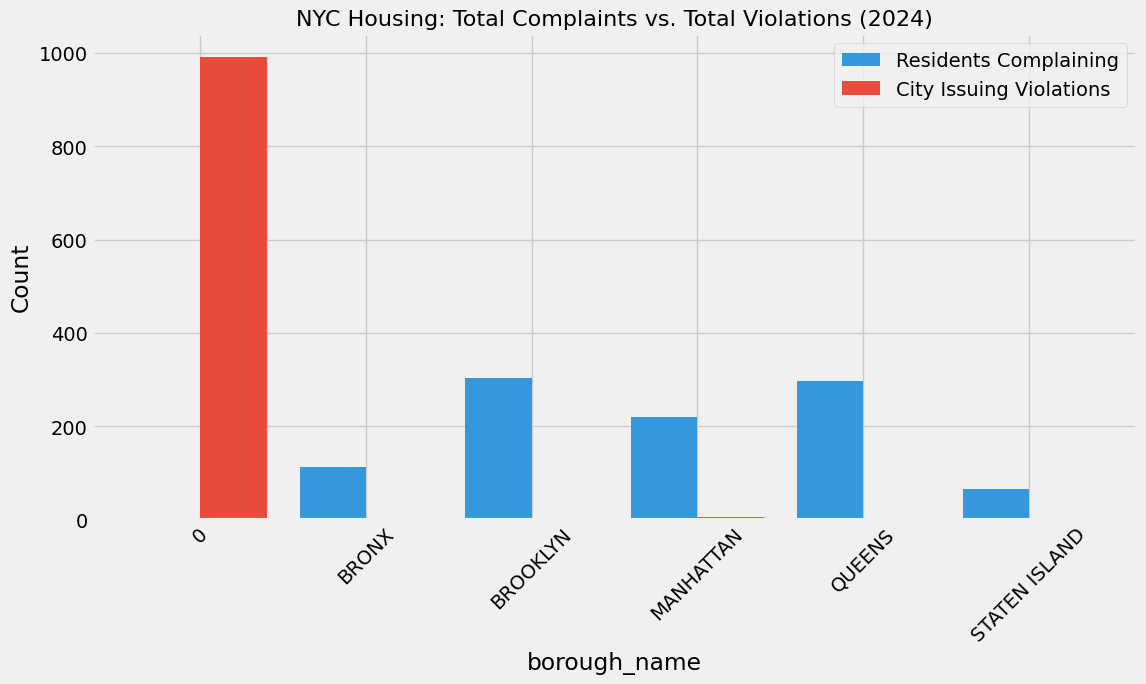

C:\Users\klmic\AppData\Local\Temp\ipykernel_6268\2512217371.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_summary.index, y=stats_summary['conversion_pct'], palette='magma')


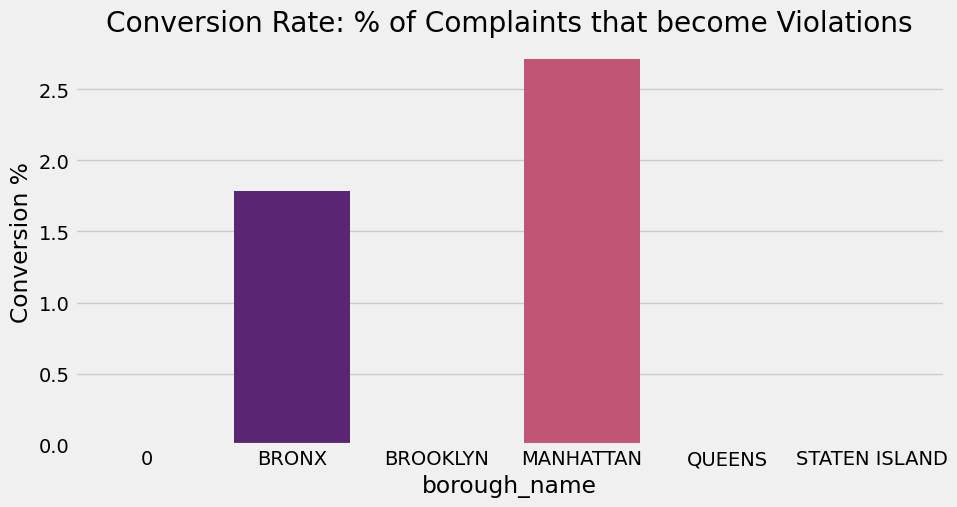

TOP 5 BUILDINGS WITH NO ACCOUNTABILITY (High Complaints / Zero Violations):
          bin borough_name  complaint_count
122   1019591    MANHATTAN              2.0
1593  4438544       QUEENS              2.0
2     1000865    MANHATTAN              1.0
1281  4034372       QUEENS              1.0
1263  4023051       QUEENS              1.0


In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URLs for your 2024 filtered endpoints
complaints_url = "https://data.cityofnewyork.us/resource/eabe-havv.json?$query=SELECT%20complaint_number,%20status,%20date_entered,%20bin,%20complaint_category%20WHERE%20date_entered%20BETWEEN%20%2201/01/2024%2012:00:00AM%22%20AND%20%2212/31/2024%2011:59:59PM%22&$limit=50000"
violations_url = "https://data.cityofnewyork.us/resource/3h2n-5cm9.json?$query=SELECT%20isn_dob_bis_viol,%20boro,%20bin,%20issue_date,%20violation_type,%20description%20WHERE%20issue_date%20BETWEEN%20%2220240101%22%20AND%20%2220241231%22&$limit=50000"

print("Fetching live 2024 data from NYC Open Data...")
r_comp = requests.get(complaints_url)
r_viol = requests.get(violations_url)

if r_comp.status_code == 200 and r_viol.status_code == 200:
    df_comp = pd.DataFrame(r_comp.json())
    df_viol = pd.DataFrame(r_viol.json())
    print(f"Loaded {len(df_comp)} Complaints and {len(df_viol)} Violations.")
else:
    print("Error fetching data. Check your connection.")

# Cell 2: The Borough Fix & Data Cleaning
# Mapping Boro codes (1=MN, 2=BX, 3=BK, 4=QN, 5=SI)
boro_map = {'1': 'MANHATTAN', '2': 'BRONX', '3': 'BROOKLYN', '4': 'QUEENS', '5': 'STATEN ISLAND'}

# Apply the fix: Extracting Borough from BIN (first digit)
df_comp['borough_name'] = df_comp['bin'].str[0].map(boro_map)
df_viol['borough_name'] = df_viol['boro'].map(boro_map) # Violations uses 'boro' column

# Ensure dates are usable
df_comp['date_entered'] = pd.to_datetime(df_comp['date_entered'])
df_viol['issue_date'] = pd.to_datetime(df_viol['issue_date'])

# Cell 3: Comparison Logic
# Group by BIN to find building-level patterns
comp_stats = df_comp.groupby(['bin', 'borough_name']).size().reset_index(name='complaint_count')
viol_stats = df_viol.groupby('bin').size().reset_index(name='violation_count')

# Merge datasets to see the 'Gap'
comparison = pd.merge(comp_stats, viol_stats, on='bin', how='outer').fillna(0)
comparison['conversion_rate'] = (comparison['violation_count'] / comparison['complaint_count']) * 100

#The Accountability Gap
plt.style.use('fivethirtyeight')
plot_data = comparison.groupby('borough_name')[['complaint_count', 'violation_count']].sum()

fig, ax = plt.subplots(figsize=(12, 6))
plot_data.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], width=0.8)
ax.set_title('NYC Housing: Total Complaints vs. Total Violations (2024)', fontsize=16)
ax.set_ylabel('Count')
ax.legend(['Residents Complaining', 'City Issuing Violations'])
plt.xticks(rotation=45)
plt.show()

#Conversion Rate (Efficiency)
stats_summary = comparison.groupby('borough_name').sum()
stats_summary['conversion_pct'] = (stats_summary['violation_count'] / stats_summary['complaint_count']) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=stats_summary.index, y=stats_summary['conversion_pct'], palette='magma')
plt.title('Conversion Rate: % of Complaints that become Violations')
plt.ylabel('Conversion %')
plt.show()

# Buildings with highest complaints but ZERO violations
neglected = comparison[comparison['violation_count'] == 0].sort_values(by='complaint_count', ascending=False)
print("TOP 5 BUILDINGS WITH NO ACCOUNTABILITY (High Complaints / Zero Violations):")
print(neglected[['bin', 'borough_name', 'complaint_count']].head(5))